In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy, mean_absolute_error
from keras.optimizers import Adam
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.utils import Sequence

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import glob
import cv2
import sys
from tqdm import tqdm
from matplotlib.pyplot import imshow
%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_small_dataset():
    imgs = np.asarray([cv2.imread(x) for x in tqdm(glob.glob("training_observations2/*.png")[:300])])
    print(imgs.shape)
    x_train = imgs[:128, :]
    x_test = imgs[128:, :]
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    y_train = np.array([])
    y_test = np.array([])
    image_size = imgs.shape[1]
    input_shape = (image_size, image_size, 3)
    
    return x_train, y_train, x_test, y_test, image_size, input_shape

x_train, y_train, x_test, y_test, image_size, input_shape = load_small_dataset()
print(x_train.max())

100%|██████████| 300/300 [00:00<00:00, 4815.65it/s]

(300, 84, 84, 3)
1.0


In [3]:
# network parameters
batch_size = 128
latent_dim = 100

# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x_inputs = Conv2D(filters=32, kernel_size=4, activation='relu', strides=2,
                  padding='same')(inputs)
x_inputs = Conv2D(filters=32, kernel_size=4, activation='relu', strides=2,
                  padding='same')(x_inputs)
x_inputs = Conv2D(filters=64, kernel_size=4, activation='relu', strides=2,
                  padding='same')(x_inputs)
x_inputs = Conv2D(filters=64, kernel_size=4, activation='relu', strides=2,
                  padding='same')(x_inputs)

x_inputs = Flatten()(x_inputs)
z = Dense(latent_dim, name='z', activation='linear')(x_inputs)

# instantiate encoder model
encoder = Model(inputs, z, name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,))
x_decoder = Dense(6 * 6 * 64, activation='relu')(latent_inputs)
x_decoder = Reshape((6, 6, 64))(x_decoder)

x_decoder = Conv2DTranspose(filters=64, kernel_size=4, activation='relu',
                            strides=2, padding='same')(x_decoder)
x_decoder = Conv2DTranspose(filters=64, kernel_size=4, activation='relu',
                            strides=2, padding='same')(x_decoder)
x_decoder = Conv2DTranspose(filters=32, kernel_size=4, activation='relu',
                            strides=2, padding='same')(x_decoder)
x_decoder = Conv2DTranspose(filters=32, kernel_size=4, activation='relu',
                            strides=2, padding='same')(x_decoder)

x_decoder = Conv2DTranspose(filters=3, kernel_size=1, strides=1,
                            activation='linear', padding='same')(x_decoder)
x_decoder = Lambda(lambda x: x[:, :84, :84, :])(x_decoder)

# instantiate decoder model
decoder = Model(latent_inputs, x_decoder, name='decoder')
decoder.summary()

# instantiate VAE model
vae = Model(inputs, decoder(encoder(inputs)), name='vae')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 84, 84, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 32)        1568      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        16416     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        32832     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 64)          65600     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
z (D

In [4]:
learning_rate = 1e-3

adam = Adam(lr=learning_rate)
vae.compile(optimizer=adam, loss='mse')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 84, 84, 3)         0         
_________________________________________________________________
encoder (Model)              (None, 100)               346916    
_________________________________________________________________
decoder (Model)              (None, 84, 84, 3)         413219    
Total params: 760,135
Trainable params: 760,135
Non-trainable params: 0
_________________________________________________________________


In [5]:
class DataSequence(Sequence):
    def __init__(self, batch_size=128):
        self.batch_size = batch_size
        self.filenames = glob.glob("training_observations2/*.png")
        self.image_size = 84
        self.on_epoch_end()
        
    def on_epoch_end(self):
        np.random.shuffle(self.filenames)
    
    def __len__(self):
        return int(np.floor(len(self.filenames) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_x = np.asarray([cv2.imread(x) for x in self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]])
        batch_x = batch_x.astype('float32') / 255.
        random_top = np.random.randint(0, self.image_size, self.batch_size)
        random_bottom = np.array([np.random.randint(x, self.image_size) for x in random_top])
        random_left = np.random.randint(0, self.image_size, self.batch_size)
        random_right = np.array([np.random.randint(x, self.image_size) for x in random_left])
        batch_x_masked = []
        for i in range(batch_x.shape[0]):
            img = batch_x[i, :]
            img[random_top[i]:random_bottom[i], random_left[i]:random_right[i], :] = 0.
            batch_x_masked.append(img)
        batch_x_masked = np.asarray(batch_x_masked)
        return batch_x_masked, batch_x
        

In [6]:
epochs = 5
checkpoint = ModelCheckpoint('denoising_autoencoder_checkpoint.h5', monitor='val_loss', 
                             verbose=0, save_best_only=True, mode='min', save_weights_only=True)

img_generator = DataSequence(batch_size=batch_size)

history = vae.fit_generator(img_generator, epochs=epochs, 
                            workers=7, callbacks=[checkpoint], validation_data=(x_test, x_test))


vae.save_weights('denoising_autoencoder.h5')
# vae.load_weights('denoising_autoencoder.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
14056/14056 [==============================] - 630s 45ms/step - loss: 0.0064 - val_loss: 0.0023
Epoch 2/5
14056/14056 [==============================] - 627s 45ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 3/5
14056/14056 [==============================] - 627s 45ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 4/5
14056/14056 [==============================] - 627s 45ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 5/5
14056/14056 [==============================] - 627s 45ms/step - loss: 0.0017 - val_loss: 0.0016


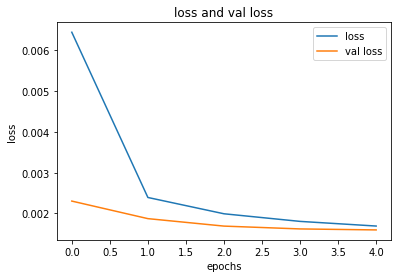

In [7]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='loss')
plt.plot(val_loss, label='val loss')
plt.title("loss and val loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

train
1.0 0.5861411 0.0
1.2812868 0.5952552 -0.10345326


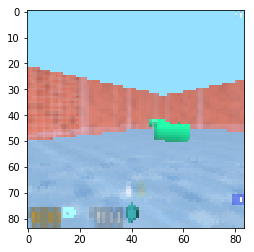

In [19]:
predicted_imgs = vae.predict(x_test, batch_size=batch_size)
print("train")
print(x_train.max(), x_train.mean(), x_train.min())
print(predicted_imgs.max(), predicted_imgs.mean(), predicted_imgs.min())
imshow(x_test[127])

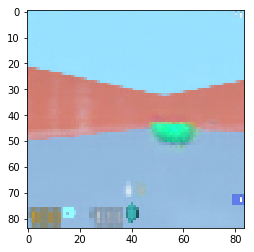

In [20]:
predicted_imgs = np.clip(predicted_imgs, 0., 1.)
imshow(predicted_imgs[127])

In [10]:
# # Test the autoencoder
# predicted_outputs = vae.predict(x_test, batch_size=batch_size)
# predicted_imgs = predicted_outputs[2]
# print("test")
# print(x_test.max(), x_test.min(), x_test.mean())
# print(predicted_imgs.max(), predicted_imgs.min(), predicted_imgs.mean())
# # x_test *= 255.
# # predicted_imgs *= 255.
# for i in range(3):
#     print(x_test[i].shape)
#     imshow(x_test[i, :])
# #     imshow(predicted_imgs[i])